# Introduction

Notebook to aggregate the running of models in the context of traceability between **features** and **bug reports**.

# Load Libraries and Datasets

In [1]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

from modules.models_runner import feat_br_strat_runner
from modules.utils import aux_functions
from modules.utils import firefox_dataset_p2 as fd

import warnings; warnings.simplefilter('ignore')

features = fd.Datasets.read_features_df()
bugreports = fd.Datasets.read_selected_bugreports_df()


Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)


# Run All Models

## Intersec Strategy

In [2]:
exp_vol_intersec_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Intersec_Strat_Runner()
exp_vol_intersec_strat_runner.execute()

evaluator_2 = exp_vol_intersec_strat_runner.get_evaluator() 
evals_df_2 = exp_vol_intersec_strat_runner.get_evals_df()

Expert and Volunteers Matrix INTERSEC.shape: (91, 19)
Features.shape: (19, 8)
SelectedBugReports.shape: (91, 18)
Running LSI model -----
Running LDA model -----
Running BM25 model -----
Running W2V model -----
Running ZeroR model -----
Expert and Volunteers Matrix INTERSEC.shape: (91, 19)
major_target_artifact: ['new_awesome_bar']
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 
Evaluating ZERO_R Model ----- 


### Results

In [3]:
evals_df_2.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,26.37,70.59,52.86,0.0,1.0,Bug_Number 1248267 1248268 125...
1,lsi,top_1_cosine_0.1,26.37,70.59,52.86,0.1,1.0,Bug_Number 1248267 1248268 125...
2,lsi,top_1_cosine_0.2,26.37,70.59,52.86,0.2,1.0,Bug_Number 1248267 1248268 125...
3,lsi,top_1_cosine_0.3,26.37,70.59,52.86,0.3,1.0,Bug_Number 1248267 1248268 125...
4,lsi,top_1_cosine_0.4,26.37,70.59,52.86,0.4,1.0,Bug_Number 1248267 1248268 125...


In [4]:
evals_df_2_1 = evals_df_2[evals_df_2.top != 19.0]
aux_functions.highlight_df( evals_df_2_1[['model','perc_precision','perc_recall','perc_fscore','top']].groupby(['model','top']).mean())

### Plots

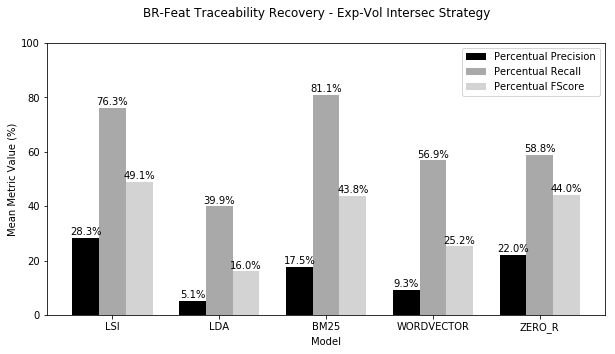

In [5]:
evaluator_2.plot_evaluations_3(evals_df_2_1, title='BR-Feat Traceability Recovery - Exp-Vol Intersec Strategy')

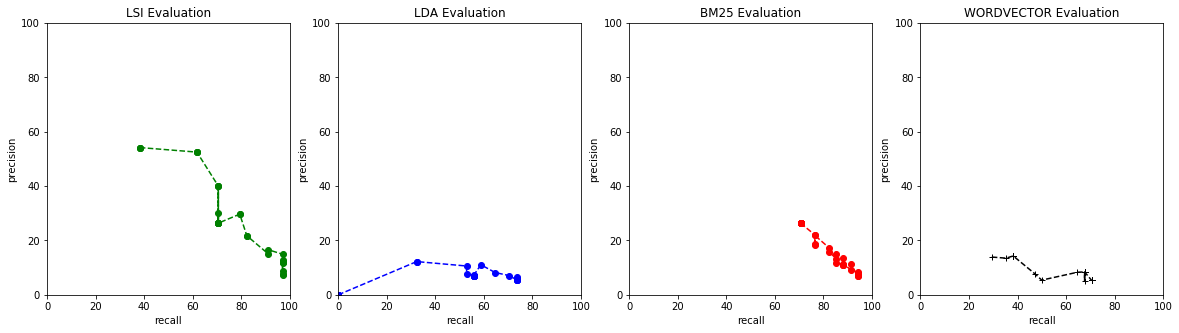

In [6]:
evaluator_2.plot_evaluations_4(evals_df_2_1)

In [7]:
## evaluator_2.plot_evaluations_5(evals_df_2_1)

**Similarity Threshold Variation Analysis**

LSI

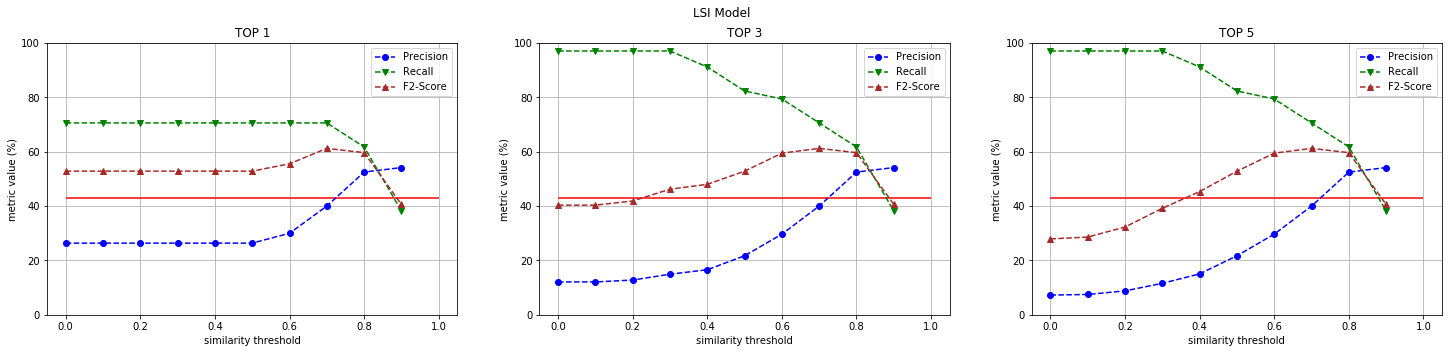

In [8]:
evaluator_2.plot_evaluations_2('LSI Model', evals_df_2, model_name='lsi')

LDA

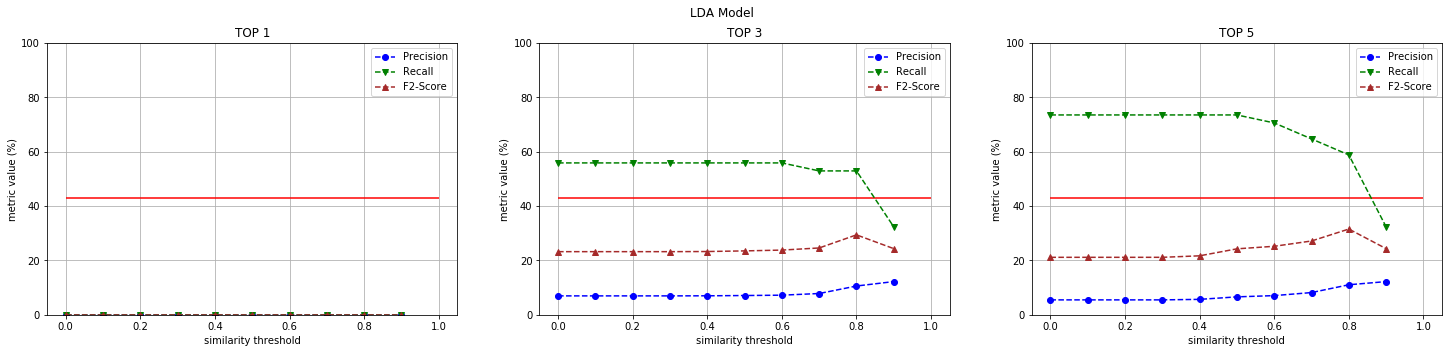

In [9]:
evaluator_2.plot_evaluations_2('LDA Model', evals_df_2, model_name='lda')

BM25

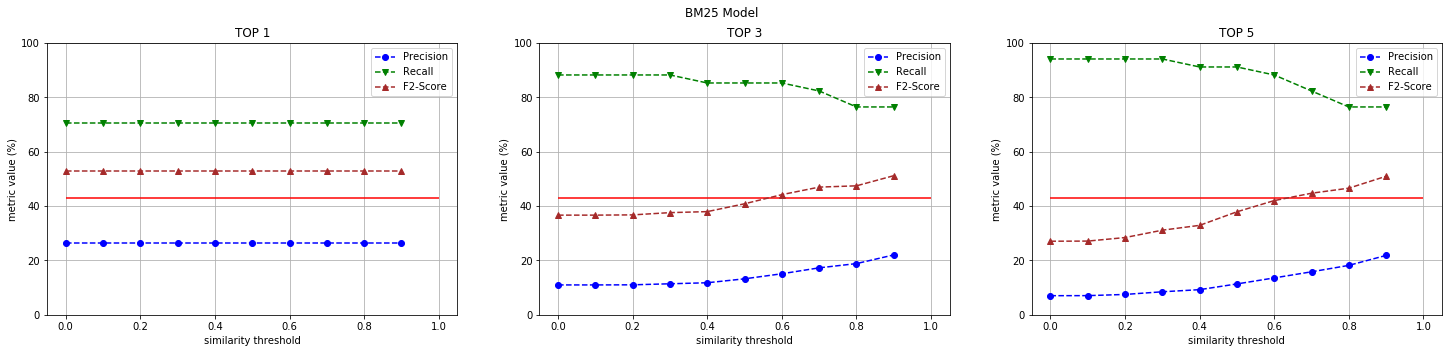

In [10]:
evaluator_2.plot_evaluations_2('BM25 Model', evals_df_2, model_name='bm25')

Word Vector

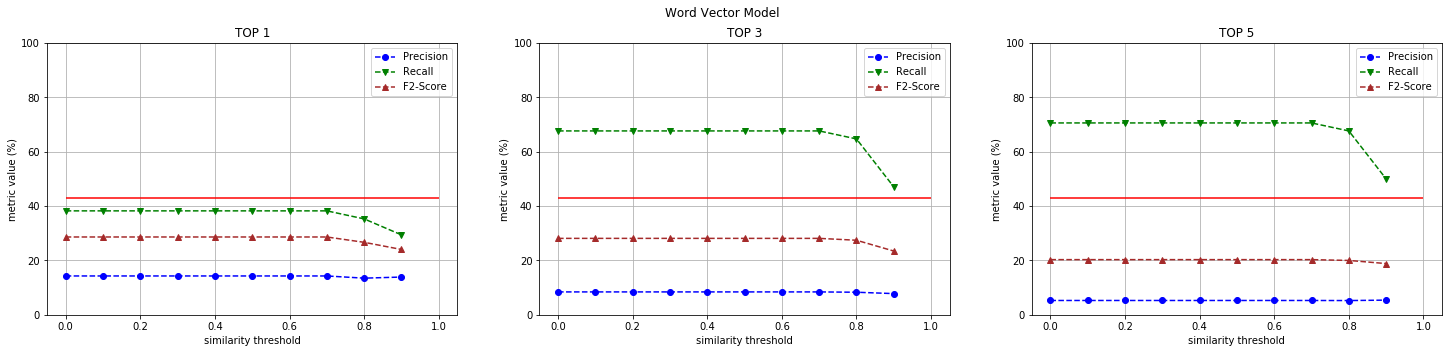

In [11]:
evaluator_2.plot_evaluations_2('Word Vector Model', evals_df_2, model_name='wordvector')

### Approach Example

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lsi_model().get_sim_matrix().iloc[:,0:3])

In [ ]:
aux_functions.highlight_df(evals_df_2_1[(evals_df_2_1.model == 'lsi') & (evals_df_2_1.ref_name == 'top_3_cosine_0.0')].trace_links_df.values[0].iloc[:,0:3])

### Oracle True Traces

In [ ]:
oracle_true_traces_inter = aux_functions.get_oracle_true_positives(exp_vol_intersec_strat_runner)
print('len(oracle_true_traces_inter): {}'.format(len(oracle_true_traces_inter)))

#### Oracle

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_evaluator().get_oracle_df().head())

#### Number of BRs for Feature

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(columns=['feature','num_brs'])
output = exp_vol_intersec_strat_runner.get_evaluator().get_oracle_df().apply(lambda row : np.sum(row), axis=1)
df.feature = output.index
df.num_brs = output.values
df = df[df.num_brs != 0]
df

### ZeroR Evaluation

In [ ]:
df = exp_vol_intersec_strat_runner.get_zeror_model().get_major_counts_df()
df.rename(columns={0:'feature',1:'num_BRs'})

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_zeror_model().get_sim_matrix())

### Retrieved Traces - Similarity Threshold 0.0

In [ ]:
retrieved_traces_df = aux_functions.get_retrieved_traces_df(oracle=exp_vol_intersec_strat_runner.get_oracle(), evals_df=evals_df_2, top_values=[1,3,5], sim_threshs=[0.0])
retrieved_traces_df[['top','sim_thresh','model','num_TP','num_FP','num_FN','precision','recall','fscore']].head(50)

#### Traces Not Captured by Any Technique

In [ ]:
import pprint

print('TOP 1 --------------------------')
all_captured_traces_t1_inter = aux_functions.get_captured_traces_union(top_value=1, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t1_inter = oracle_true_traces_inter - all_captured_traces_t1_inter
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t1_inter)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t1_inter), len(oracle_true_traces_inter), len(not_captured_traces_t1_inter)/len(oracle_true_traces_inter)*100))
pprint.pprint(not_captured_traces_t1_inter)

print('\n\nTOP 3 --------------------------')
all_captured_traces_t3_inter = aux_functions.get_captured_traces_union(top_value=3, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t3_inter = oracle_true_traces_inter - all_captured_traces_t3_inter
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t3_inter)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t3_inter), len(oracle_true_traces_inter), len(not_captured_traces_t3_inter)/len(oracle_true_traces_inter)*100))

print('\n\nTOP 5 --------------------------')
all_captured_traces_t5_inter = aux_functions.get_captured_traces_union(top_value=5, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t5_inter = oracle_true_traces_inter - all_captured_traces_t5_inter
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t5_inter)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t5_inter), len(oracle_true_traces_inter), len(not_captured_traces_t5_inter)/len(oracle_true_traces_inter)*100))

#### Traces Captured by Every Technique

In [ ]:
print('TOP 1 -----------------------')
traces_captured_by_all_t1_inter = aux_functions.get_captured_traces_intersec(1, retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t1_inter)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t1_inter), len(oracle_true_traces_inter), len(traces_captured_by_all_t1_inter)/len(oracle_true_traces_inter) *100))

print('\n\nTOP 3 -----------------------')
traces_captured_by_all_t3_inter = aux_functions.get_captured_traces_intersec(3, retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t3_inter)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t3_inter), len(oracle_true_traces_inter), len(traces_captured_by_all_t3_inter)/len(oracle_true_traces_inter) *100))

print('\n\nTOP 5 -----------------------')
traces_captured_by_all_t5_inter = aux_functions.get_captured_traces_intersec(5, retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t5_inter)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t5_inter), len(oracle_true_traces_inter), len(traces_captured_by_all_t5_inter)/len(oracle_true_traces_inter) *100))

#### Similarity Matrices Analysis

##### **LDA**

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lda_model().get_sim_matrix())

##### **LSI**

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lsi_model().get_sim_matrix())

##### **BM25**

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_bm25_model().get_sim_matrix())

##### **Word Vector**

In [ ]:
import numpy as np

wv_sim_matrix = exp_vol_intersec_strat_runner.get_word2vec_model().get_sim_matrix()

wv_sim_values = []
for idx,row in wv_sim_matrix.iterrows():
    for col in wv_sim_matrix.columns:
        wv_sim_values.append(wv_sim_matrix.at[idx,col])

print("Mean Similarity Value: {}".format(np.mean(wv_sim_values)))
print("Std Similarity Value: {}".format(np.std(wv_sim_values)))

aux_functions.highlight_df(wv_sim_matrix)

#### LDA Topics

In [ ]:
exp_vol_intersec_strat_runner.get_lda_model().print_topics()

#### True Positives Analysis

In [ ]:
bm25_tp_set_t1, lsi_tp_set_t1, lda_tp_set_t1, wv_tp_set_t1 = aux_functions.get_traces_set(retrieved_traces_df, 1, 'TP')
bm25_tp_set_t3, lsi_tp_set_t3, lda_tp_set_t3, wv_tp_set_t3 = aux_functions.get_traces_set(retrieved_traces_df, 3, 'TP')
bm25_tp_set_t5, lsi_tp_set_t5, lda_tp_set_t5, wv_tp_set_t5 = aux_functions.get_traces_set(retrieved_traces_df, 5, 'TP')
#aux_functions.plot_venn_diagrams(TOP, bm25_tp_set_t5, lsi_tp_set_t5, lda_tp_set_t5, wv_tp_set_t5, 'True Positives')

##### Exclusive Traces

In [ ]:
import pandas as pd

print("TOP 1 ------------------------------")
bm25_tp_exc_set_t1, lsi_tp_exc_set_t1, lda_tp_exc_set_t1, wv_tp_exc_set_t1 =  aux_functions.get_exclusive_traces(bm25_tp_set_t1, lsi_tp_set_t1, lda_tp_set_t1, wv_tp_set_t1, traces_type='TP', verbose=True)

print("\n\nTOP 3 ------------------------------")
bm25_tp_exc_set_t3, lsi_tp_exc_set_t3, lda_tp_exc_set_t3, wv_tp_exc_set_t3 =  aux_functions.get_exclusive_traces(bm25_tp_set_t3, lsi_tp_set_t3, lda_tp_set_t3, wv_tp_set_t3, traces_type='TP', verbose=True)

print("\n\nTOP 5 -------------------------------")
bm25_tp_exc_set_t5, lsi_tp_exc_set_t5, lda_tp_exc_set_t5, wv_tp_exc_set_t5 =  aux_functions.get_exclusive_traces(bm25_tp_set_t5, lsi_tp_set_t5, lda_tp_set_t5, wv_tp_set_t5, traces_type='TP', verbose=True)

df = pd.DataFrame(index=['TOP 1', 'TOP 3', 'TOP 5'], columns=['BM25','LSI','LDA','WordVector'])

df.at['TOP 1','BM25'] = len(bm25_tp_exc_set_t1)
df.at['TOP 3','BM25'] = len(bm25_tp_exc_set_t3)
df.at['TOP 5','BM25'] = len(bm25_tp_exc_set_t5)

df.at['TOP 1','LSI'] = len(lsi_tp_exc_set_t1)
df.at['TOP 3','LSI'] = len(lsi_tp_exc_set_t3)
df.at['TOP 5','LSI'] = len(lsi_tp_exc_set_t5)

df.at['TOP 1','LDA'] = len(lda_tp_exc_set_t1)
df.at['TOP 3','LDA'] = len(lda_tp_exc_set_t3)
df.at['TOP 5','LDA'] = len(lda_tp_exc_set_t5)

df.at['TOP 1','WordVector'] = len(wv_tp_exc_set_t1)
df.at['TOP 3','WordVector'] = len(wv_tp_exc_set_t3)
df.at['TOP 5','WordVector'] = len(wv_tp_exc_set_t5)

print()

df

#### False Positives Analysis

In [ ]:
bm25_fp_set_t1, lsi_fp_set_t1, lda_fp_set_t1, wv_fp_set_t1 = aux_functions.get_traces_set(retrieved_traces_df, 1, 'FP')
bm25_fp_set_t5, lsi_fp_set_t5, lda_fp_set_t5, wv_fp_set_t5 = aux_functions.get_traces_set(retrieved_traces_df, 5, 'FP')

aux_functions.plot_venn_diagrams(1, bm25_fp_set_t1, lsi_fp_set_t1, lda_fp_set_t1, wv_fp_set_t1, 'FP')
print('====================')
aux_functions.plot_venn_diagrams(5, bm25_fp_set_t5, lsi_fp_set_t5, lda_fp_set_t5, wv_fp_set_t5, 'FP')

##### Exclusive Traces

In [ ]:
print("TOP 1 ------------------------------")
bm25_fp_exc_set_t1, lsi_fp_exc_set_t1, lda_fp_exc_set_t1, wv_fp_exc_set_t1 =  aux_functions.get_exclusive_traces(bm25_fp_set_t1, lsi_fp_set_t1, lda_fp_set_t1, wv_fp_set_t1, traces_type='FP')

print("\n\nTOP 5 -------------------------------")
bm25_fp_exc_set_t5, lsi_fp_exc_set_t5, lda_fp_exc_set_t5, wv_fp_exc_set_t5 =  aux_functions.get_exclusive_traces(bm25_fp_set_t5, lsi_fp_set_t5, lda_fp_set_t5, wv_fp_set_t5, traces_type='FP')

#### False Negatives Analysis

In [ ]:
bm25_fn_set_t1, lsi_fn_set_t1, lda_fn_set_t1, wv_fn_set_t1 = aux_functions.get_traces_set(retrieved_traces_df, 1, 'FN')
bm25_fn_set_t5, lsi_fn_set_t5, lda_fn_set_t5, wv_fn_set_t5 = aux_functions.get_traces_set(retrieved_traces_df, 5, 'FN')

aux_functions.plot_venn_diagrams(5, bm25_fn_set_t5, lsi_fn_set_t5, lda_fn_set_t5, wv_fn_set_t5, 'False Negatives')

##### Exclusive Traces

In [ ]:
print("TOP 1 ------------------------------")
bm25_fn_exc_set_t1, lsi_fn_exc_set_t1, lda_fn_exc_set_t1, wv_fn_exc_set_t1 =  aux_functions.get_exclusive_traces(bm25_fn_set_t1, lsi_fn_set_t1, lda_fn_set_t1, wv_fn_set_t1, traces_type='FN')

print("\n\nTOP 5 -------------------------------")
bm25_fn_exc_set_t5, lsi_fn_exc_set_t5, lda_fn_exc_set_t5, wv_fn_exc_set_t5 =  aux_functions.get_exclusive_traces(bm25_fn_set_t5, lsi_fn_set_t5, lda_fn_set_t5, wv_fn_set_t5, traces_type='FN')

##### **LDA**

In [ ]:
aux_functions.detail_features_br(lda_fn_exc_set_t1, features, bugreports)[['feat','br','br_summary']]

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lda_model().get_sim_matrix().loc[:,[b for f,b in lda_fn_exc_set_t1]])

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lda_model().get_sim_matrix().loc[:,[b for f,b in lda_fn_exc_set_t1 - set([1270983,1248267,1299458])]])

##### **LSI**

No exclusive False Negative traces for Top 1 and Top 5

##### **BM25**

No exclusive False Negative traces for Top 1 and Top 5

##### **Word Vector**

In [ ]:
aux_functions.detail_features_br(wv_fn_exc_set_t5, features, bugreports)[['feat','br','br_summary']]

In [ ]:
aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_word2vec_model().get_sim_matrix().loc[:,[b for f,b in wv_fn_exc_set_t5]])

### Retrieved Traces - Similarity Threshold 0.9

In [ ]:
retrieved_traces_df = aux_functions.get_retrieved_traces_df(oracle=exp_vol_intersec_strat_runner.get_oracle(), evals_df=evals_df_2, top_values=[1,3,5], sim_threshs=[0.9])
retrieved_traces_df[['top','sim_thresh','model','num_TP','num_FP','num_FN','precision','recall','fscore']].head(50)

#### Traces Not Captured by Any Technique

In [ ]:
import pprint

print('TOP 1 --------------------------')
all_captured_traces_t1_inter = aux_functions.get_captured_traces_union(top_value=1, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t1_inter = oracle_true_traces_inter - all_captured_traces_t1_inter
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t1_inter)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t1_inter), len(oracle_true_traces_inter), len(not_captured_traces_t1_inter)/len(oracle_true_traces_inter)*100))
pprint.pprint(not_captured_traces_t1_inter)

print('\n\nTOP 3 --------------------------')
all_captured_traces_t3_inter = aux_functions.get_captured_traces_union(top_value=3, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t3_inter = oracle_true_traces_inter - all_captured_traces_t3_inter
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t3_inter)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t3_inter), len(oracle_true_traces_inter), len(not_captured_traces_t3_inter)/len(oracle_true_traces_inter)*100))
pprint.pprint(not_captured_traces_t3_inter)

print('\n\nTOP 5 --------------------------')
all_captured_traces_t5_inter = aux_functions.get_captured_traces_union(top_value=5, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t5_inter = oracle_true_traces_inter - all_captured_traces_t5_inter
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t5_inter)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t5_inter), len(oracle_true_traces_inter), len(not_captured_traces_t5_inter)/len(oracle_true_traces_inter)*100))
pprint.pprint(not_captured_traces_t5_inter)

#### Traces Captured by Every Technique

In [ ]:
import pprint

print('TOP 1 -----------------------')
traces_captured_by_all_t1_inter = aux_functions.get_captured_traces_intersec(1, retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t1_inter)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t1_inter), len(oracle_true_traces_inter), len(traces_captured_by_all_t1_inter)/len(oracle_true_traces_inter) *100))
pprint.pprint(traces_captured_by_all_t1_inter)

print('\n\nTOP 3 -----------------------')
traces_captured_by_all_t3_inter = aux_functions.get_captured_traces_intersec(3, retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t3_inter)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t3_inter), len(oracle_true_traces_inter), len(traces_captured_by_all_t3_inter)/len(oracle_true_traces_inter) *100))
pprint.pprint(traces_captured_by_all_t3_inter)

print('\n\nTOP 5 -----------------------')
traces_captured_by_all_t5_inter = aux_functions.get_captured_traces_intersec(5, retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t5_inter)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t5_inter), len(oracle_true_traces_inter), len(traces_captured_by_all_t5_inter)/len(oracle_true_traces_inter) *100))
pprint.pprint(traces_captured_by_all_t5_inter)

#### True Positives Analysis

In [ ]:
bm25_tp_set_t1, lsi_tp_set_t1, lda_tp_set_t1, wv_tp_set_t1 = aux_functions.get_traces_set(retrieved_traces_df, 1, 'TP')
bm25_tp_set_t3, lsi_tp_set_t3, lda_tp_set_t3, wv_tp_set_t3 = aux_functions.get_traces_set(retrieved_traces_df, 3, 'TP')
bm25_tp_set_t5, lsi_tp_set_t5, lda_tp_set_t5, wv_tp_set_t5 = aux_functions.get_traces_set(retrieved_traces_df, 5, 'TP')
#aux_functions.plot_venn_diagrams(TOP, bm25_tp_set_t5, lsi_tp_set_t5, lda_tp_set_t5, wv_tp_set_t5, 'True Positives')

##### Exclusive Traces

In [ ]:
import pandas as pd

print("TOP 1 ------------------------------")
bm25_tp_exc_set_t1, lsi_tp_exc_set_t1, lda_tp_exc_set_t1, wv_tp_exc_set_t1 =  aux_functions.get_exclusive_traces(bm25_tp_set_t1, lsi_tp_set_t1, lda_tp_set_t1, wv_tp_set_t1, traces_type='TP', verbose=True)

print("\n\nTOP 3 ------------------------------")
bm25_tp_exc_set_t3, lsi_tp_exc_set_t3, lda_tp_exc_set_t3, wv_tp_exc_set_t3 =  aux_functions.get_exclusive_traces(bm25_tp_set_t3, lsi_tp_set_t3, lda_tp_set_t3, wv_tp_set_t3, traces_type='TP', verbose=True)

print("\n\nTOP 5 -------------------------------")
bm25_tp_exc_set_t5, lsi_tp_exc_set_t5, lda_tp_exc_set_t5, wv_tp_exc_set_t5 =  aux_functions.get_exclusive_traces(bm25_tp_set_t5, lsi_tp_set_t5, lda_tp_set_t5, wv_tp_set_t5, traces_type='TP', verbose=True)

df = pd.DataFrame(index=['TOP 1', 'TOP 3', 'TOP 5'], columns=['BM25','LSI','LDA','WordVector'])

df.at['TOP 1','BM25'] = len(bm25_tp_exc_set_t1)
df.at['TOP 3','BM25'] = len(bm25_tp_exc_set_t3)
df.at['TOP 5','BM25'] = len(bm25_tp_exc_set_t5)

df.at['TOP 1','LSI'] = len(lsi_tp_exc_set_t1)
df.at['TOP 3','LSI'] = len(lsi_tp_exc_set_t3)
df.at['TOP 5','LSI'] = len(lsi_tp_exc_set_t5)

df.at['TOP 1','LDA'] = len(lda_tp_exc_set_t1)
df.at['TOP 3','LDA'] = len(lda_tp_exc_set_t3)
df.at['TOP 5','LDA'] = len(lda_tp_exc_set_t5)

df.at['TOP 1','WordVector'] = len(wv_tp_exc_set_t1)
df.at['TOP 3','WordVector'] = len(wv_tp_exc_set_t3)
df.at['TOP 5','WordVector'] = len(wv_tp_exc_set_t5)

print()

df

##### Details of Exclusive Traces

In [ ]:
display(aux_functions.detail_features_br(bm25_tp_exc_set_t1, features, bugreports)[['feat','br','br_summary']])
display(aux_functions.detail_features_br(bm25_tp_exc_set_t3, features, bugreports)[['feat','br','br_summary']])
display(aux_functions.detail_features_br(wv_tp_exc_set_t3, features, bugreports)[['feat','br','br_summary']])
display(aux_functions.detail_features_br(wv_tp_exc_set_t5, features, bugreports)[['feat','br','br_summary']])

**LSI vs BM25 Similarity Matrices Comparison - TOP 1**

In [ ]:
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lsi_model().get_sim_matrix().loc[:,[b for f,b in bm25_tp_exc_set_t1]]))
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_bm25_model().get_sim_matrix().loc[:,[b for f,b in bm25_tp_exc_set_t1]]))

**LSI vs BM25 Similarity Matrices Comparison - TOP 3 and 5**

In [ ]:
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lsi_model().get_sim_matrix().loc[:,[b for f,b in bm25_tp_exc_set_t3]]))
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_bm25_model().get_sim_matrix().loc[:,[b for f,b in bm25_tp_exc_set_t3]]))

**BM25 vs WV Similarity Matrices Comparison - TOP 3**

In [ ]:
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_bm25_model().get_sim_matrix().loc[:,[b for f,b in wv_tp_exc_set_t5]]))
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_word2vec_model().get_sim_matrix().loc[:,[b for f,b in wv_tp_exc_set_t5]]))

#### False Positives Analysis

In [ ]:
bm25_fp_set_t1, lsi_fp_set_t1, lda_fp_set_t1, wv_fp_set_t1 = aux_functions.get_traces_set(retrieved_traces_df, 1, 'FP')
bm25_fp_set_t3, lsi_fp_set_t3, lda_fp_set_t3, wv_fp_set_t3 = aux_functions.get_traces_set(retrieved_traces_df, 3, 'FP')
bm25_fp_set_t5, lsi_fp_set_t5, lda_fp_set_t5, wv_fp_set_t5 = aux_functions.get_traces_set(retrieved_traces_df, 5, 'FP')

aux_functions.plot_venn_diagrams(1, bm25_fp_set_t1, lsi_fp_set_t1, lda_fp_set_t1, wv_fp_set_t1, 'FP')
print('====================')
aux_functions.plot_venn_diagrams(3, bm25_fp_set_t3, lsi_fp_set_t3, lda_fp_set_t3, wv_fp_set_t3, 'FP')
print('====================')
aux_functions.plot_venn_diagrams(5, bm25_fp_set_t5, lsi_fp_set_t5, lda_fp_set_t5, wv_fp_set_t5, 'FP')

##### Exclusive Traces

In [ ]:
print("TOP 1 ------------------------------")
bm25_fp_exc_set_t1, lsi_fp_exc_set_t1, lda_fp_exc_set_t1, wv_fp_exc_set_t1 =  aux_functions.get_exclusive_traces(bm25_fp_set_t1, lsi_fp_set_t1, lda_fp_set_t1, wv_fp_set_t1, traces_type='FP')

print("\n\nTOP 3 ------------------------------")
bm25_fp_exc_set_t3, lsi_fp_exc_set_t3, lda_fp_exc_set_t3, wv_fp_exc_set_t3 =  aux_functions.get_exclusive_traces(bm25_fp_set_t3, lsi_fp_set_t3, lda_fp_set_t3, wv_fp_set_t3, traces_type='FP')

print("\n\nTOP 5 -------------------------------")
bm25_fp_exc_set_t5, lsi_fp_exc_set_t5, lda_fp_exc_set_t5, wv_fp_exc_set_t5 =  aux_functions.get_exclusive_traces(bm25_fp_set_t5, lsi_fp_set_t5, lda_fp_set_t5, wv_fp_set_t5, traces_type='FP')

#### False Negatives Analysis

In [ ]:
bm25_fn_set_t1, lsi_fn_set_t1, lda_fn_set_t1, wv_fn_set_t1 = aux_functions.get_traces_set(retrieved_traces_df, 1, 'FN')
bm25_fn_set_t3, lsi_fn_set_t3, lda_fn_set_t3, wv_fn_set_t3 = aux_functions.get_traces_set(retrieved_traces_df, 3, 'FN')
bm25_fn_set_t5, lsi_fn_set_t5, lda_fn_set_t5, wv_fn_set_t5 = aux_functions.get_traces_set(retrieved_traces_df, 5, 'FN')

print("TOP 1 -----------------------------------")
aux_functions.plot_venn_diagrams(1, bm25_fn_set_t1, lsi_fn_set_t1, lda_fn_set_t1, wv_fn_set_t1, 'FN')

print("\n\nTOP 5 -----------------------------------")
aux_functions.plot_venn_diagrams(5, bm25_fn_set_t5, lsi_fn_set_t5, lda_fn_set_t5, wv_fn_set_t5, 'FN')

##### Exclusive Traces

In [ ]:
print("TOP 1 ------------------------------")
bm25_fn_exc_set_t1, lsi_fn_exc_set_t1, lda_fn_exc_set_t1, wv_fn_exc_set_t1 =  aux_functions.get_exclusive_traces(bm25_fn_set_t1, lsi_fn_set_t1, lda_fn_set_t1, wv_fn_set_t1, traces_type='FN', verbose=True)

print("\n\nTOP 3 -------------------------------")
bm25_fn_exc_set_t3, lsi_fn_exc_set_t3, lda_fn_exc_set_t3, wv_fn_exc_set_t3 =  aux_functions.get_exclusive_traces(bm25_fn_set_t3, lsi_fn_set_t3, lda_fn_set_t3, wv_fn_set_t3, traces_type='FN', verbose=True)

print("\n\nTOP 5 -------------------------------")
bm25_fn_exc_set_t5, lsi_fn_exc_set_t5, lda_fn_exc_set_t5, wv_fn_exc_set_t5 =  aux_functions.get_exclusive_traces(bm25_fn_set_t5, lsi_fn_set_t5, lda_fn_set_t5, wv_fn_set_t5, traces_type='FN', verbose=True)

##### Detail False Negatives

In [ ]:
display(aux_functions.detail_features_br(lda_fn_exc_set_t1, features, bugreports)[['feat','br','br_summary']])
display(aux_functions.detail_features_br(lda_fn_exc_set_t5, features, bugreports)[['feat','br','br_summary']])

In [ ]:
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lda_model().get_sim_matrix().loc[:,[b for f,b in lda_fn_exc_set_t1]]))
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lda_model().get_sim_matrix().loc[:,[b for f,b in lda_fn_exc_set_t5]]))

##### Word Vector FN Details

In [ ]:
display(aux_functions.detail_features_br(wv_fn_exc_set_t3, features, bugreports)[['feat','br','br_summary']])
display(aux_functions.detail_features_br(wv_fn_exc_set_t5, features, bugreports)[['feat','br','br_summary']])

In [ ]:
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_word2vec_model().get_sim_matrix().loc[:,[b for f,b in wv_fn_exc_set_t3]]))
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_word2vec_model().get_sim_matrix().loc[:,[b for f,b in wv_fn_exc_set_t5]]))

##### LSI FN Details

In [ ]:
display(aux_functions.detail_features_br(lsi_fn_exc_set_t3, features, bugreports)[['feat','br','br_summary']])
display(aux_functions.detail_features_br(lsi_fn_exc_set_t5, features, bugreports)[['feat','br','br_summary']])

In [ ]:
display(aux_functions.highlight_df(exp_vol_intersec_strat_runner.get_lsi_model().get_sim_matrix().loc[:,[b for f,b in lsi_fn_exc_set_t3]]))

### Recovery Effort Index (REI)

In [ ]:
orc_vol_only_precision = 36.56
def calculate_rei(row):
    if row['precision'] > 0:
        return orc_vol_only_precision/row['precision']
    return 0

In [ ]:
retrieved_traces_df['rei'] = retrieved_traces_df.apply(lambda row : calculate_rei(row), axis=1)
retrieved_traces_df[['top','model','precision','recall','rei']].groupby('model').rei.mean()

### Goodness Scale

In [ ]:
aux_functions.calculate_goodness(evals_df_2_1)

### Delete Variables

## Volunteers Only Strategy

In [ ]:
vol_strat_runner = feat_br_strat_runner.Feat_BR_Vol_Strat_Runner()
vol_strat_runner.execute()

evaluator_4 = vol_strat_runner.get_evaluator() 
evals_df_4 = vol_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_4.head()

In [ ]:
evals_df_4_1 = evals_df_4[evals_df_4.top != 19.0]
aux_functions.highlight_df( evals_df_4_1[['model','perc_precision','perc_recall','perc_fscore','top']].groupby(['model','top']).mean())

### Plots

In [ ]:
evaluator_4.plot_evaluations_3(evals_df_4_1, title='BR-Feat Traceability Recovery - Volunteers-Only Strategy')

In [ ]:
evaluator_4.plot_evaluations_4(evals_df_4_1)

In [ ]:
evaluator_4.plot_evaluations_5(evals_df_4_1)

### Retrieved Traces - Similarity Threshold 0.0

In [ ]:
retrieved_traces_df = aux_functions.get_retrieved_traces_df(oracle=vol_strat_runner.get_oracle(), evals_df = evals_df_4)
retrieved_traces_df.head(50)

### Oracle True Traces

In [ ]:
oracle_true_traces_vol = aux_functions.get_oracle_true_positives(vol_strat_runner)
print('len(oracle_true_traces): {}'.format(len(oracle_true_traces_vol)))

### Traces Not Captured by Any Technique

In [ ]:
print('TOP 1 --------------------------')
all_captured_traces_t1_vol = aux_functions.get_captured_traces_union(top_value=1, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t1_vol = oracle_true_traces_vol - all_captured_traces_t1_vol
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t1_vol)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t1_vol), len(oracle_true_traces_vol), len(not_captured_traces_t1_vol)/len(oracle_true_traces_vol)*100))

print('\n\nTOP 3 --------------------------')
all_captured_traces_t3_vol = aux_functions.get_captured_traces_union(top_value=3, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t3_vol = oracle_true_traces_vol - all_captured_traces_t3_vol
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t3_vol)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t3_vol), len(oracle_true_traces_vol), len(not_captured_traces_t3_vol)/len(oracle_true_traces_vol)*100))

print('\n\nTOP 5 --------------------------')
all_captured_traces_t5_vol = aux_functions.get_captured_traces_union(top_value=5, retrieved_traces_df=retrieved_traces_df)
not_captured_traces_t5_vol = oracle_true_traces_vol - all_captured_traces_t5_vol
print('len(not_captured_traces): {}'.format(len(not_captured_traces_t5_vol)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces_t5_vol), len(oracle_true_traces_vol), len(not_captured_traces_t5_vol)/len(oracle_true_traces_vol)*100))

#### Details of not captured traces

In [ ]:
aux_functions.detail_features_br(not_captured_traces, features=features, bugreports=bugreports)

### Traces Captured by Every Technique

In [ ]:
print('TOP 1 -----------------------')
traces_captured_by_all_t1_vol = aux_functions.get_captured_traces_intersec(1, retrieved_traces_df=retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t1_vol)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t1_vol), len(oracle_true_traces_vol), len(traces_captured_by_all_t1_vol)/len(oracle_true_traces_vol) *100))

print('\n\nTOP 3 -----------------------')
traces_captured_by_all_t3_vol = aux_functions.get_captured_traces_intersec(3, retrieved_traces_df=retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t3_vol)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t3_vol), len(oracle_true_traces_vol), len(traces_captured_by_all_t3_vol)/len(oracle_true_traces_vol) *100))

print('\n\nTOP 5 -----------------------')
traces_captured_by_all_t5_vol = aux_functions.get_captured_traces_intersec(5, retrieved_traces_df=retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all_t5_vol)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all_t5_vol), len(oracle_true_traces_vol), len(traces_captured_by_all_t5_vol)/len(oracle_true_traces_vol) *100))

### REI Calculation

In [ ]:
evals_df_4_2 = evals_df_4[(evals_df_4.top == 19.0) & (evals_df_4.sim_threshold == 0.0)]
evals_df_4_2.head()

In [ ]:
volunteers_perc_precision = 36.56
lsi_rei = volunteers_perc_precision / evals_df_4_2[evals_df_4_2.model == 'lsi'].iloc[0,:].perc_precision
lda_rei = volunteers_perc_precision / evals_df_4_2[evals_df_4_2.model == 'lda'].iloc[0,:].perc_precision 
bm25_rei= volunteers_perc_precision / evals_df_4_2[evals_df_4_2.model == 'bm25'].iloc[0,:].perc_precision 
wv_rei =  volunteers_perc_precision / evals_df_4_2[evals_df_4_2.model == 'wordvector'].iloc[0,:].perc_precision

print('LSI REI: {:2.4}%'.format(lsi_rei))
print('LDA REI: {:2.4}%'.format(lda_rei))
print('BM25 REI: {:2.4}%'.format(bm25_rei))
print('WV REI: {:2.4}%'.format(wv_rei))

### Delete Variables

## Union Strategy

In [ ]:
exp_vol_union_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Vol_Union_Strat_Runner()
exp_vol_union_strat_runner.execute()

evaluator_1 = exp_vol_union_strat_runner.get_evaluator() 
evals_df_1 = exp_vol_union_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_1.head()

### Plots

In [ ]:
evaluator_1.plot_evaluations_3(evals_df_1, title='BR-Feat Traceability Recovery - Exp-Vol Union Strategy')

In [ ]:
evaluator_1.plot_evaluations_4(evals_df_1)

In [ ]:
evaluator_1.plot_evaluations_5(evals_df_1)

### Delete Variables

## Expert Only Strategy

In [ ]:
exp_strat_runner = feat_br_strat_runner.Feat_BR_Exp_Strat_Runner()
exp_strat_runner.execute()

evaluator_3 = exp_strat_runner.get_evaluator() 
evals_df_3 = exp_strat_runner.get_evals_df()

### Results

In [ ]:
evals_df_3.head()

In [ ]:
evals_df_3_1 = evals_df_3[evals_df_3.top != 19.0]
aux_functions.highlight_df( evals_df_3_1[['model','perc_precision','perc_recall','perc_fscore','top']].groupby(['model','top']).mean())

### Plots

In [ ]:
evaluator_3.plot_evaluations_3(evals_df_3_1, title='BR-Feat Traceability Recovery - Expert-Only Strategy')

In [ ]:
evaluator_3.plot_evaluations_4(evals_df_3_1)

In [ ]:
evaluator_3.plot_evaluations_5(evals_df_3_1)

### Retrieved Traces - Similarity Threshold 0.0

In [ ]:
retrieved_traces_df = aux_functions.get_retrieved_traces_df(oracle=exp_strat_runner.get_oracle(), evals_df = evals_df_3)
retrieved_traces_df.head(50)

### Oracle True Traces

In [ ]:
oracle_true_traces = aux_functions.get_oracle_true_positives(exp_strat_runner)
print('len(oracle_true_traces): {}'.format(len(oracle_true_traces)))

### Traces Not Captured by Any Technique

In [ ]:
print('TOP 1 --------------------------')
all_captured_traces = aux_functions.get_captured_traces_union(top_value=1, retrieved_traces_df=retrieved_traces_df)
not_captured_traces = oracle_true_traces - all_captured_traces
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

print('\n\nTOP 3 --------------------------')
all_captured_traces = aux_functions.get_captured_traces_union(top_value=3, retrieved_traces_df=retrieved_traces_df)
not_captured_traces = oracle_true_traces - all_captured_traces
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

print('\n\nTOP 5 --------------------------')
#from modules.utils import firefox_dataset_p2 as fd
all_captured_traces = aux_functions.get_captured_traces_union(top_value=5, retrieved_traces_df=retrieved_traces_df)
not_captured_traces = oracle_true_traces - all_captured_traces
#aux_functions.detail_features_br(not_captured_traces, features=fd.Datasets.read_features_df(), bugreports=fd.Datasets.read_selected_bugreports_df())
print('len(not_captured_traces): {}'.format(len(not_captured_traces)))
print('percent not_captured_traces: {}/{} * 100 : {:2.4}%'.format(len(not_captured_traces), len(oracle_true_traces), len(not_captured_traces)/len(oracle_true_traces)*100))

### Traces Captured by Every Technique

In [ ]:
print('TOP 1 -----------------------')
traces_captured_by_all = aux_functions.get_captured_traces_intersec(1, retrieved_traces_df=retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

print('\n\nTOP 3 -----------------------')
traces_captured_by_all = aux_functions.get_captured_traces_intersec(3, retrieved_traces_df=retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

print('\n\nTOP 5 -----------------------')
traces_captured_by_all = aux_functions.get_captured_traces_intersec(5, retrieved_traces_df=retrieved_traces_df)
print('len(traces_captured_by_all): {}'.format(len(traces_captured_by_all)))
print('percent traces_captured_by_all: {}/{} * 100 : {:2.4}%'.format(len(traces_captured_by_all), len(oracle_true_traces), len(traces_captured_by_all)/len(oracle_true_traces) *100))

### Delete Variables